### Create ATB oil capacity weights by # AIS ship tracks by:
1. not-scaled values and
2. values scaled by median ping intervals

In [1]:
import sys
import yaml
import pathlib
import numpy
import pandas
import matplotlib.pyplot as plt
from monte_carlo_utils import make_bins, get_bin, place_into_bins

In [2]:
input_directory = pathlib.Path(
    '/Users/rmueller/Data/MIDOSS/marine_transport_data/'
)

### open master yaml file for 
with open(input_directory/'master.yaml') as file:
    master = yaml.load(file, Loader=yaml.Loader)
    
#~~~ atb traffic ~~~
# C: "AIS ship track frequency"
# D: "Median ship track distance (km)"
# K: "Vessel length (AIS)"
# L: "Vessel Length (AIS + <50 m correction)"
# O: "Total Fuel Capacity (liters)"
# P: "Cargo Capacity (liters)"

atb_df = pandas.read_excel(
    master['files']['oil_capacity'],
    sheet_name='atb', 
    usecols='A,C,D,K,L,O,P',
    header=1
)
atb_data_df = pandas.read_excel(
    master['files']['oil_capacity'],
    sheet_name='atb data', 
    usecols='A,B,D,E'
)

In [3]:
for ind in range(len(atb_data_df['MMSI'])):
    print(ind,atb_data_df['MMSI'][ind], atb_df['MMSI'][ind], atb_df['AIS ship tracks'][ind], atb_data_df['COUNT'][ind])

0 303668000 303668000.0 20420.0 20420
1 316001221 316001221.0 30690.0 30690
2 316001223 316001223.0 20609.0 20609
3 316006101 316006101.0 39378.0 39378
4 316038089 316038089.0 26245.0 26245
5 338134000 338134000.0 33730.0 33730
6 338616000 338616000.0 43829.0 43829
7 366341000 366341000.0 8181.0 8181
8 366904000 366904000.0 16114.0 16114
9 367449870 367449870.0 936.0 936
10 367646810 367646810.0 23025.0 23025
11 367740790 367740790.0 56503.0 56503
12 367770980 367770980.0 68194.0 68194
13 367770990 367770990.0 63122.0 63122
14 368006870 368006870.0 97016.0 97016
15 368013040 368013040.0 13752.0 13752
16 369580000 369580000.0 19729.0 19729
17 369703000 369703000.0 6663.0 6663


In [7]:
# create line fit for atbs with length > 50 m
# fit = coefficient[1] + coefficient[0] * length
good_values = atb_df['Vessel Length (AIS + <50 m correction)']>0

# create fuel and cargo capacity bins into which vessel traffic information 
# is sorted to determine oil capacity weights. 
[cargo_bins, cargo_bin_centers]  = make_bins(
    lower_bound =  4000000,
    upper_bound = 30000000,
    step_size   = 2000000
)

# ~~~~~~~~~~~~~~~~~~~~ ORIGINAL WAY ~~~~~~~~~~~~~~~~~~~~~~~~
# we use this estimate of distance traveled by each atb in 2018 to weight
# oil capacity allocation for vessels that don't have a clear allocation 
atb_distance = (atb_df['AIS ship tracks'] * 
     atb_df['Median ship track distance (km)'])

### cargo weights ###
# bin distance travelled by cargo capacity and sum distances for each 
# cargo capacity bin to create cargo capacity weights
binned_atb_distance_by_cargo = place_into_bins(
    atb_df['Cargo Capacity (liters)'], 
    atb_distance, 
    cargo_bins
)


# ~~~~~~~~~~~~~~~~~~~~ NEW WAY ~~~~~~~~~~~~~~~~~~~~~~~~
# we use this estimate of distance traveled by each atb in 2018 to weight
# oil capacity allocation for vessels that don't have a clear allocation 
atb_tracks = (atb_df['AIS ship tracks'] * 
     atb_data_df['Median time between pings (minutes)']/
     numpy.mean(atb_data_df['Median time between pings (minutes)'])
)

### cargo weights ###
# bin distance travelled by cargo capacity and sum distances for each 
# cargo capacity bin to create cargo capacity weights
binned_atb_tracks_by_cargo = place_into_bins(
    atb_df['Cargo Capacity (liters)'], 
    atb_tracks, 
    cargo_bins
)

### Plot comparison of old vs. new way

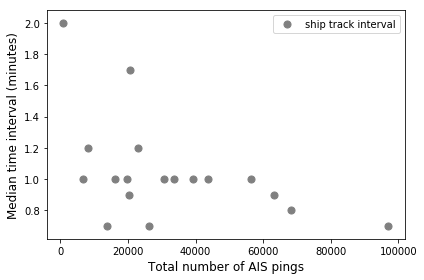

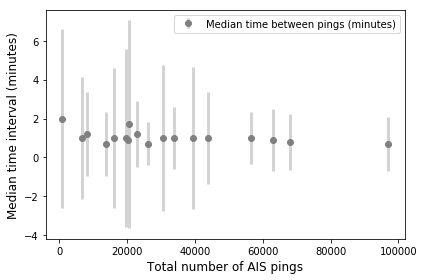

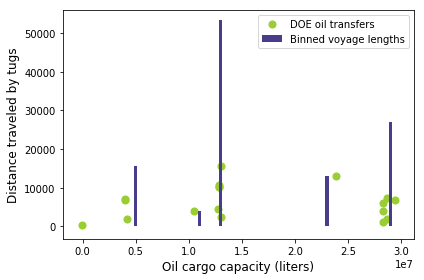

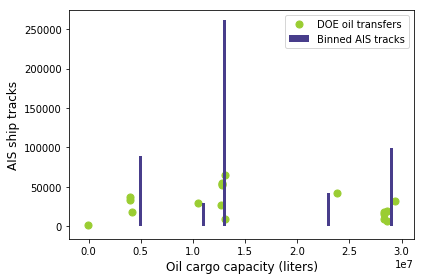

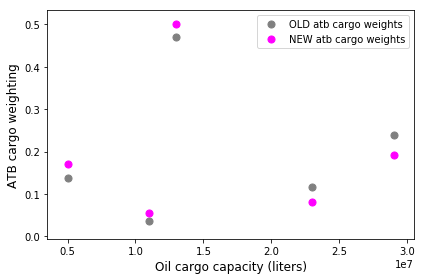

In [51]:
#~~~~ PLOT ship tracks by time interval ~~~~~~~~~~~~~~~~~~~~~
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(
    atb_data_df['COUNT'],
    atb_data_df['Median time between pings (minutes)'],
    50,
    label='ship track interval',
    color='grey'
)
plt.xlabel('Total number of AIS pings',fontsize=12)
plt.ylabel('Median time interval (minutes)',fontsize=12)
plt.tight_layout()
ax1.legend()
plt.show() 

#~~~~ PLOT ship tracks by time interval (with errorbars) ~~~~
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.errorbar(
    atb_data_df['COUNT'],
    atb_data_df['Median time between pings (minutes)'],
    yerr=atb_data_df['Standard deviation (minutes)']/2,
    fmt='o', 
    color='grey',
    ecolor='lightgray', 
    elinewidth=3, 
    capsize=0,
    ls='none'
)
# ax1.scatter(
#     atb_data_df['COUNT'],
#     atb_data_df['Median time between pings (minutes)'],
#     50,
#     label='ship track interval',
#     color='grey'
# )
plt.xlabel('Total number of AIS pings',fontsize=12)
plt.ylabel('Median time interval (minutes)',fontsize=12)
plt.tight_layout()
ax1.legend()
plt.show() 

#~~~~ PLOT ORIGINAL METHOD ~~~~
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.bar(
    cargo_bin_centers,
    binned_atb_distance_by_cargo,
    width=0.3e6,
    label='Binned voyage lengths',
    color='darkslateblue'
)
ax1.scatter(
    atb_df['Cargo Capacity (liters)'],
    atb_distance,
    50,
    label='DOE oil transfers',
    color='yellowgreen'
)
plt.xlabel('Oil cargo capacity (liters)',fontsize=12)
plt.ylabel('Distance traveled by tugs',fontsize=12)
plt.tight_layout()
ax1.legend()
plt.show() 

#~~~~ PLOT NEW METHOD ~~~~
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.bar(
    cargo_bin_centers,
    binned_atb_tracks_by_cargo,
    width=0.3e6,
    label='Binned AIS tracks',
    color='darkslateblue'
)
ax1.scatter(
    atb_df['Cargo Capacity (liters)'],
    atb_tracks,
    50,
    label='DOE oil transfers',
    color='yellowgreen'
)
plt.xlabel('Oil cargo capacity (liters)',fontsize=12)
plt.ylabel('AIS ship tracks',fontsize=12)
plt.tight_layout()
ax1.legend()
plt.show() 

#~~~~ PLOT oil cargo weighting ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
old_weight = binned_atb_distance_by_cargo/sum(binned_atb_distance_by_cargo)
new_weight = binned_atb_tracks_by_cargo/sum(binned_atb_tracks_by_cargo)

old_weight[numpy.where(old_weight==0)[0]]=numpy.nan
new_weight[numpy.where(new_weight==0)[0]]=numpy.nan

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(
    cargo_bin_centers,
    old_weight,
    50,
    label='OLD atb cargo weights',
    color='grey'
)
ax1.scatter(
    cargo_bin_centers,
    new_weight,
    50,
    label='NEW atb cargo weights',
    color='magenta'
)
plt.xlabel('Oil cargo capacity (liters)',fontsize=12)
plt.ylabel('ATB cargo weighting',fontsize=12)
plt.tight_layout()
ax1.legend()
plt.show()



In [12]:
atb_data_df

,MMSI,COUNT,Median time between pings (minutes),Standard deviation (minutes)
0,303668000,20420,0.9,1.9
1,316001221,30690,1.0,7.5
2,316001223,20609,1.7,10.7
3,316006101,39378,1.0,7.3
4,316038089,26245,0.7,2.2
5,338134000,33730,1.0,3.2
6,338616000,43829,1.0,4.7
7,366341000,8181,1.2,4.3
8,366904000,16114,1.0,7.2
9,367449870,936,2.0,9.2


In [41]:
sum(old_weight)

1.0

In [42]:
sum(new_weight)

1.0000000000000002